In [1]:
%config Completer.use_jedi = False
# reload magic
%reload_ext autoreload
%autoreload 2
import numpy as np

from terrain_slope import load_shp, mapping, dotProduct

# filename = "/work/handong28/database/terrain_slope/terrain_slope.shp"
filename = "/bk2/handsomedong/DLRA_database/terrain_slope/GIS_terrain.shp"
# ec_filedir = "/work/handong28/database/ERA5_reanalysis"
ec_filedir = "/bk2/handsomedong/DLRA_database/ERA5_reanalysis"

df = load_shp(filename)
target_map, latList, lonList = df.getMap("高程")
new_map, new_lat, new_lon = mapping(latList, lonList, target_map, (120,120))
# new_map[new_map == 0] = np.nan # aspect 0 == None; 360 == Northward

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43953/43953 [00:01<00:00, 36249.77it/s]

Latitude Range: 24.0625~25.55, Longitude Range: 120.6875~122.175 for cropped TW [120x120]


In [6]:
def blurness(data, k_size=3):
    # Moving Average
    # data shape = [H, W]
    pd = k_size//2
    tmp = np.pad(data, ((pd,pd), (pd,pd)), 'constant')
    tmpp = np.copy(tmp)
    for i in range(pd, tmp.shape[0]-pd):
        for j in range(pd, tmp.shape[1]-pd):
            tmpp[i, j] = tmp[i-pd:i+pd+1, j-pd:j+pd+1].mean()
    return tmpp[pd:-pd, pd:-pd]

(120.6875, 122.1875, 24.0625, 25.5625)

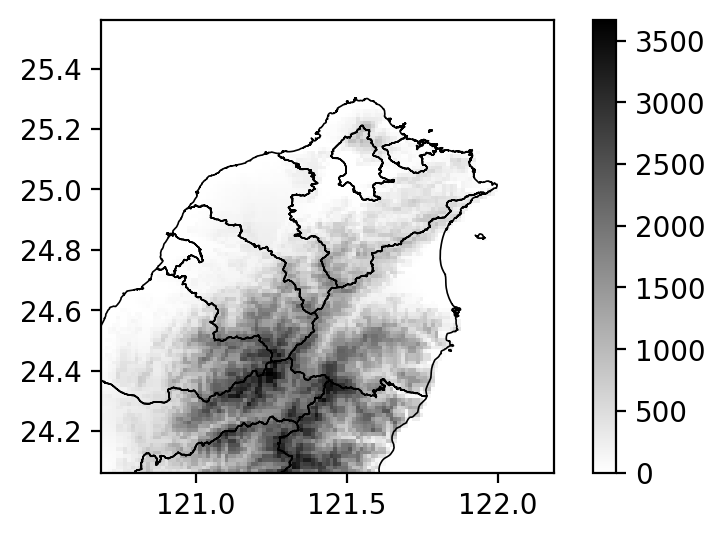

In [2]:
import matplotlib.pyplot as plt
import scipy.io as sio
mat = sio.loadmat('/wk171/handsomedong/after_Meeting/evaluation/city_lonlat_region5.mat')
citylon = mat['citylon']
citylat = mat['citylat']
### model axis
terrain_lat = np.linspace(20,27,561)[325:445]
terrain_lon = np.linspace(118,123.5,441)[215:335]


plt.figure(figsize=(5, 3), dpi=200)
plt.plot(citylon,citylat,'k',linewidth=0.6)
# plt.imshow(new_map, norm=None, aspect='equal', origin='lower', cmap='binary')
plt.imshow(new_map, norm=None, aspect='equal', cmap='binary', 
           extent=[terrain_lon[0],terrain_lon[-1],terrain_lat[-1],terrain_lat[0]],)
plt.colorbar()
plt.axis([120.6875, 122.1875, 24.0625, 25.5625])# whole area [119, 123, 21, 26]

In [3]:
# if new_map is loaded from "高程", please set is_elevation=True.
dot = dotProduct(new_map, ec_filedir)

(120.6875, 122.1875, 24.0625, 25.5625)

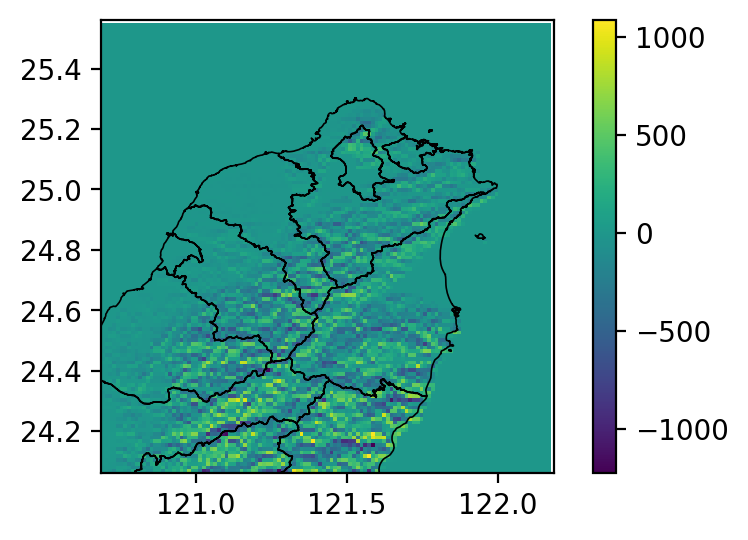

In [4]:
# slope check
output1, output2 = dot.forward(is_elevation=True)
plt.figure(figsize=(5, 3), dpi=200)
plt.plot(citylon,citylat,'k',linewidth=0.6)
plt.imshow(output2, norm=None, aspect='equal',
           extent=[terrain_lon[0],terrain_lon[-1],terrain_lat[-1],terrain_lat[0]],)
plt.colorbar()
plt.axis([120.6875, 122.1875, 24.0625, 25.5625])# whole area [119, 123, 21, 26]

(120.6875, 122.1875, 24.0625, 25.5625)

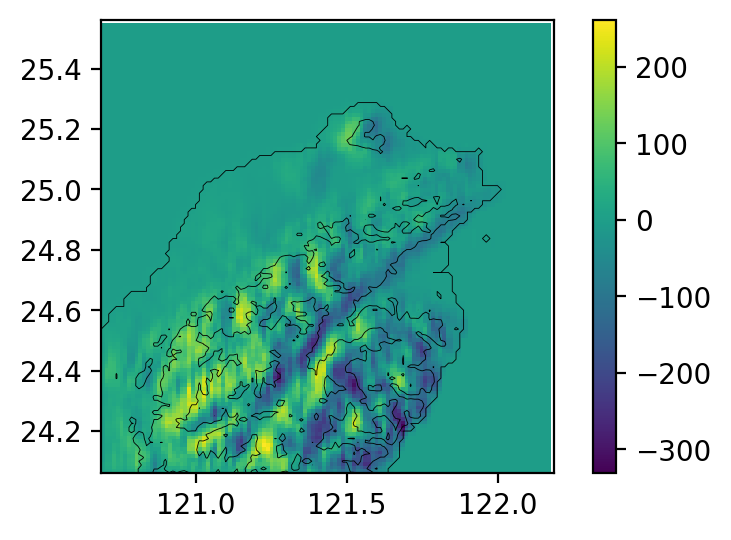

In [49]:
# b_output1 = blurness(output1, k_size=5)
# b_output2 = blurness(output2, k_size=5)
plt.figure(figsize=(5, 3), dpi=200)
# city
# plt.plot(citylon,citylat,'k',linewidth=0.6)
# terrain contour
ct = plt.contour(terrain_lon, terrain_lat, new_map, [0, 500, 1600, 3000], colors='k', linewidths=0.3)
# plt.clabel(ct, fontsize=5)
# slope
plt.imshow(b_output1, norm=None, aspect='equal',
           extent=[terrain_lon[0],terrain_lon[-1],terrain_lat[-1],terrain_lat[0]],)
plt.colorbar()
# plt.axis('equal')
plt.axis([120.6875, 122.1875, 24.0625, 25.5625])# whole area [119, 123, 21, 26]

In [61]:
from netCDF4 import Dataset
from datetime import datetime
import os
dt = datetime(2021,6,4,3,10)
# dt = datetime(2019,9,4,3,10)
filepath = os.path.join('/bk2/handsomedong/DLRA_database/ERA5_reanalysis/', str(dt.year), 
                        str(dt.year)+'{:02d}'.format(dt.month), 
                        f'era5_{dt.year}{dt.month:02}{dt.day:02}.nc',
                        )
data = Dataset(filepath, 'r')
avg_wind = []
for key in ['u', 'v']:
    wind = data.variables[key][:] # masked array [24, 20, lat, lon]
    wind[np.where(wind.mask!=0)] = np.nan
    wind = np.nanmean(wind[:, -7], axis=(-1, -2)) # -7 is 850 hpa
    avg_wind.append(wind[dt.hour]) # first u then v
ans = b_output1 * avg_wind[0] + b_output2 * avg_wind[1]

(120.6875, 122.1875, 24.0625, 25.5625)

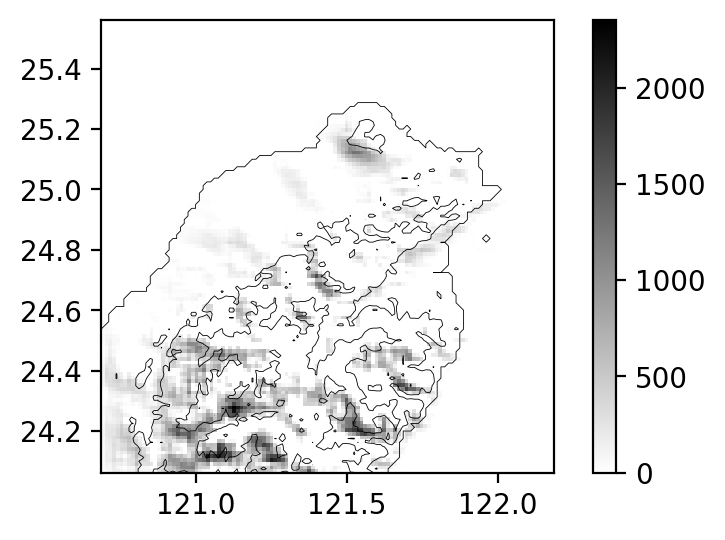

In [62]:
ans[ans<0]=0
plt.figure(figsize=(5, 3), dpi=200)
ct = plt.contour(terrain_lon, terrain_lat, new_map, [0, 500, 1600, 3000], colors='k', linewidths=0.3)
plt.imshow(ans, norm=None, aspect='equal', cmap='binary',
           extent=[terrain_lon[0],terrain_lon[-1],terrain_lat[-1],terrain_lat[0]],)
plt.colorbar()
plt.axis([120.6875, 122.1875, 24.0625, 25.5625])# whole area [119, 123, 21, 26]